# Import libraries

In [204]:
import numpy as np
import os
import shutil
from pathlib import Path
import xml.etree.ElementTree as ET
from glob import glob
import xmltodict
from PIL import Image, ImageDraw
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from PIL import Image
import yaml


# Annotations

## Reading annotations and writing yolo format labels

In [6]:
# count files
print(os.getcwd())
root_annots_path = '../data/annotations/'
root_images_path = '../data/images/'

annots_path = sorted([i for i in Path(root_annots_path).glob('*.xml')])
images_path = sorted([i for i in Path(root_images_path).glob('*.png')])
n_imgs, n_ann = len(images_path), len(annots_path)
print("Number of images and annotations {} {}".format(n_imgs, n_ann))



/home/temir/Documents/Kaggle/Siemense/notebooks
Number of images and annotations 3686 3686


In [23]:
# helper functions 
def read_object_bbox(dict_object):
    class_name = dict_object['name']
    xmin = int(dict_object['bndbox']['xmin'])
    ymin = int(dict_object['bndbox']['ymin'])
    xmax = int(dict_object['bndbox']['xmax'])
    ymax = int(dict_object['bndbox']['ymax'])
    return class_name, xmin, ymin, xmax, ymax

def read_image_data(dict_size):
    height = int(dict_size['height'])
    width = int(dict_size['width'])
    channels = int(dict_size['depth'])
    return height, width, channels



In [264]:
text_labels_dir = '../data/labels_yolo/'
os.makedirs(text_labels_dir, exist_ok = True)

annotation_list = []

for label_path in annots_path:
    with open(label_path) as file:
        file_data = file.read()  # read file contents
        # parse data using package
        dict_data = xmltodict.parse(file_data)['annotation']
        filename = dict_data['filename']
        
        # read annotations
        img_height, img_width, channels = read_image_data(dict_data['size'])
        class_name, xmin, ymin, xmax, ymax = read_object_bbox(dict_data['object'])
        
        # transform to yolo format
        x = ((xmin + xmax) / 2) / img_width
        y = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height
        class_label = 0 if class_name=='cat' else 1
        

        # All our informations
        object_ann_list=  [filename, img_height, img_width, channels, class_name, xmin, ymin, xmax, ymax, class_label,  x, y, width, height]
        
        # Saving yolo format labels
        save_file_name = os.path.join(text_labels_dir+ filename.replace("png", "txt"))
        with open(save_file_name, 'w') as f :
            f.write(" ".join([str(x) for x in object_ann_list[-5:]]))
        
        annotation_list.append(object_ann_list)
        


In [265]:
# Creating dataframe to analyze datasets    
annotation_df = pd.DataFrame(annotation_list,
    columns=["filename", "img_height", "img_width", "channels", "class_name","xmin", "ymin", "xmax", "ymax", "class_label" ,"x", "y", "width", "height",])
annotation_df.to_pickle("../data/annotation_df.pkl")

In [275]:
# To check if bbox are exits outrange of the image
annotation_df[annotation_df.img_height<annotation_df.ymax]

Empty DataFrame
Columns: [filename, img_height, img_width, channels, class_name, xmin, ymin, xmax, ymax, class_label, x, y, width, height]
Index: []

[0 rows x 14 columns]

In [276]:
annotation_df[annotation_df.img_width<annotation_df.xmax]

Empty DataFrame
Columns: [filename, img_height, img_width, channels, class_name, xmin, ymin, xmax, ymax, class_label, x, y, width, height]
Index: []

[0 rows x 14 columns]

## Analysing Images
 

In [75]:
annotation_df.head()

filename  img_height  img_width  channels class_name  class_label  \
0     Cats_Test0.png         350        233         3        cat            0   
1     Cats_Test1.png         500        500         3        dog            1   
2    Cats_Test10.png         375        500         3        dog            1   
3   Cats_Test100.png         375        500         3        cat            0   
4  Cats_Test1000.png         500        335         3        cat            0   

          x         y     width    height  
0  0.600858  0.244286  0.489270  0.322857  
1  0.368000  0.244000  0.224000  0.400000  
2  0.421000  0.229333  0.214000  0.160000  
3  0.348000  0.472000  0.128000  0.170667  
4  0.485075  0.326000  0.755224  0.596000

1    2498
0    1188
Name: class_label, dtype: int64

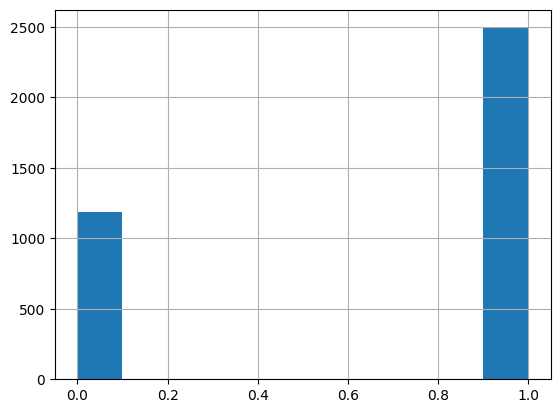

In [76]:
annotation_df.class_label.hist()
annotation_df.class_label.value_counts()
# classes are  not balanced cat are twice less than dogs
# but is should not be problem while we randomly split data so test and trains set will have same proportion of dogs and cats

In [77]:
annotation_df['area'] = annotation_df['img_width']*annotation_df['img_height']

<AxesSubplot: ylabel='Frequency'>

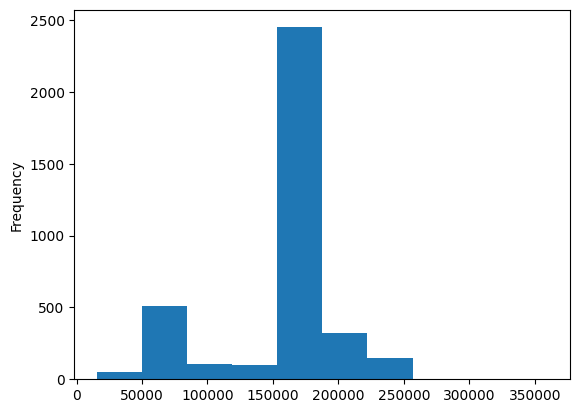

In [83]:
annotation_df['area'].plot.hist()

In [85]:
annotation_df.describe() 
# We can check here that everything is ok with x,y,w,h as they are inside of 0 and 1

img_height    img_width  channels  class_label            x  \
count  3686.000000  3686.000000    3686.0  3686.000000  3686.000000   
mean    377.466630   424.349702       3.0     0.677699     0.497839   
std      89.300112    94.009541       0.0     0.467421     0.120496   
min     108.000000   114.000000       3.0     0.000000     0.121000   
25%     333.000000   333.000000       3.0     0.000000     0.429707   
50%     375.000000   500.000000       3.0     1.000000     0.499000   
75%     500.000000   500.000000       3.0     1.000000     0.568000   
max     600.000000   600.000000       3.0     1.000000     0.908333   

                 y        width       height           area  
count  3686.000000  3686.000000  3686.000000    3686.000000  
mean      0.368137     0.411714     0.447086  160962.447640  
std       0.106439     0.187359     0.182669   47057.674922  
min       0.097619     0.054000     0.066066   15552.000000  
25%       0.291667     0.270000     0.302622  166000.000000  
50%       0.361500     0.380000     0.418667  167000.000000  
75%       0.438935     0.521935     0.564378  187500.000000  
max       0.789000     0.997403     0.997333  360000.000000

## Plotting Image and Bbox

In [157]:
def yolo_to_pascal_voc(bbox_data):
    x_center, y_center, w, h,  image_w, image_h =bbox_data
    w = w * image_w
    h = h * image_h
    x1 = ((2 * x_center * image_w) - w)/2
    y1 = ((2 * y_center * image_h) - h)/2
    x2 = x1 + w
    y2 = y1 + h
    return [x1, y1, x2, y2]

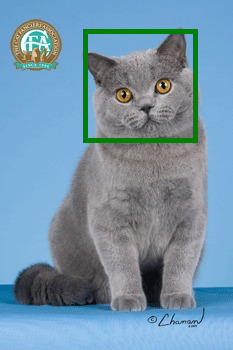

[83.0, 29.0, 197.0, 142.0]


In [246]:
def plot_img(filename, bbox):    
    #get bbox
    bbox_list = annotation_df.loc[annotation_df.filename==filename, ["x", "y", "width", "height","img_width", "img_height"]].values[0].tolist()
    bbox = yolo_to_pascal_voc(bbox_list)
    sample_image = Image.open(root_images_path + filename)
    # sample_image.show()
    x_image = sample_image.copy()
    img_bbox = ImageDraw.Draw(x_image)
    img_bbox.rectangle(bbox, outline="green",width = 5 )
    display(x_image)
    print(bbox)
    return bbox
    
filename = 'Cats_Test0.png'
bbox_cat = plot_img(filename, bbox)


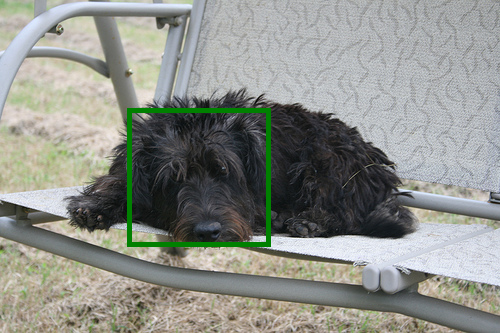

[127.0, 108.0, 270.0, 246.0]


In [247]:
filename = 'Cats_Test900.png'
bbox_dog = plot_img(filename, bbox)

# Run Inference YoloV5

## Sample  Inference

In [87]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in /home/temir/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-11 Python-3.10.8 torch-1.13.0 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [103]:
# conf = 0.25  # NMS confidence threshold
# iou = 0.45  # NMS IoU threshold
# agnostic = False  # NMS class-agnostic
# multi_label = False  # NMS multiple labels per box
# classes = [15, 16]  # (optional list) filter by class, i.e. = [0, 15, 16] for COCO persons, cats and dogs
# max_det = 1000  # maximum number of detections per image
# amp = False
model.classes = [15, 16]

In [248]:
filename1 = 'Cats_Test0.png'
filename2 = 'Cats_Test900.png'


im1 = Image.open(root_images_path + filename1) 
im2 = Image.open(root_images_path + filename2) 

results = model([im1, im2], size=320)
results

YOLOv5 <class 'models.common.Detections'> instance
image 1/2: 350x233 1 cat
image 2/2: 333x500 1 dog
Speed: 7.5ms pre-process, 24.4ms inference, 0.6ms NMS per image at shape (2, 3, 320, 320)

In [105]:
results.pandas().xyxy[0]  # im1 predictions (pandas)

xmin       ymin        xmax        ymax  confidence  class name
0  28.748392  30.900591  210.591934  312.377045    0.647688     15  cat

In [250]:
def plot_img_pred(filename,pred_bbox): 
    bbox_list = annotation_df.loc[annotation_df.filename==filename, ["x", "y", "width", "height","img_width", "img_height"]].values[0].tolist()
    true_bbox = yolo_to_pascal_voc(bbox_list)
    sample_image = Image.open(root_images_path + filename)
    x_image = sample_image.copy()
    img_bbox = ImageDraw.Draw(x_image)
    img_bbox.rectangle(true_bbox, outline="red",width = 5 )
    img_bbox.rectangle(pred_bbox, outline="green",width = 5 )
    display(x_image)

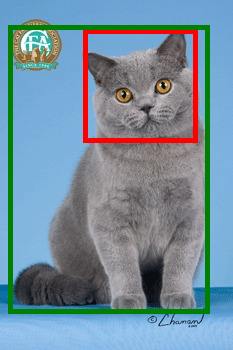

In [258]:
pred_bbox_cat = results.pandas().xyxy[0].values[0][:4].tolist()  # im2 predictions (pandas)
plot_img_pred(filename1, pred_bbox_cat)

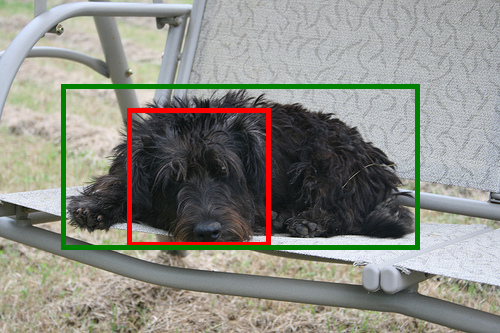

In [257]:
pred_bbox_dog = results.pandas().xyxy[1].values[0][:4].tolist()  # im2 predictions (pandas)
plot_img_pred(filename2, pred_bbox_dog)

In [186]:
# Here we can see that our annotations mainly takes faces of the cats and dogs
# While Yolo5 catches whole body.
# If we use directly inference from pretrained Yolov5s we will get low accuracy. It can be seen below.

In [259]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou


In [263]:
print("IOU cat:", bb_intersection_over_union(pred_bbox_cat, bbox_cat))
print("IOU dog:",bb_intersection_over_union(pred_bbox_dog, bbox_dog))

IOU cat: 0.22370667322597185
IOU dog: 0.33379401352430105


## Train YoloV5 for our dataset

In [233]:
images_path =glob("../data/images/*.png")
train_list_total, test_list = train_test_split(images_path, test_size = 0.2, random_state = 0)
train_list, valid_list = train_test_split(train_list_total, test_size = 0.1, random_state = 0)

In [235]:
def write_file(path, text_list):
    with open("../data/"+ path, 'w') as f:
        f.write('\n'.join(text_list) + '\n')

In [236]:
write_file('train.txt',train_list )
write_file('valid.txt',valid_list )
write_file('test.txt',test_list )

In [209]:
# from yolov5.utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages

In [237]:
with open('../data/data.yaml', 'w') as f:
    data = {
        'path':'../data/',
        'train' : 'train.txt',
        'val' : 'valid.txt',
        'test' : 'test.txt',
        'nc' : 2,
        'names' : ['cat', 'dog']
    }
    yaml.dump(data, f)

In [210]:
os.getcwd()

'/home/temir/Documents/Kaggle/Siemense/notebooks'

In [211]:
import sys  
sys.path.insert(0, '/home/temir/Documents/Kaggle/Siemense/yolov5')

In [213]:
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages

In [240]:
%cd ../yolov5

!python train.py \
--img 640 \
--batch 20 \
--epochs 10 \
--data ../data/data.yaml \
--cfg ./models/yolov5s.yaml \
--weights yolov5s.pt \
--name siemence_cat_dogs

/home/temir/Documents/Kaggle/Siemense/yolov5
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=../data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=20, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=siemence_cat_dogs, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch origin' timed out after 5 seconds
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.10.8 torch-1.13.0 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_ga

        9/9         0G    0.02219    0.01057   0.002979         27        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all        295        295      0.974      0.982      0.991      0.813

10 epochs completed in 2.124 hours.
Optimizer stripped from runs/train/siemence_cat_dogs2/weights/last.pt, 14.4MB
Optimizer stripped from runs/train/siemence_cat_dogs2/weights/best.pt, 14.4MB

Validating runs/train/siemence_cat_dogs2/weights/best.pt...
Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
                 Class     Images  Instances          P          R      mAP50   
                   all        295        295      0.974      0.982      0.991      0.813
                   cat        295         99      0.985       0.99      0.994       0.86
                   dog        295        196      0.964      0.974      0.988      0.765
Results saved to runs/train/siemence_cat_dogs2


In [243]:
# %load_ext tensorboard
# %tensorboard --logdir ../yolov5/runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Inference our trained yolov5

In [277]:
import shutil

In [286]:
import shutil
from tqdm.notebook import tqdm
    
test_list_filenames = [x.split("/")[-1] for x in test_list]
os.makedirs("../data/test_images/", exist_ok=True)

def copy_img(filename):
    source = "../data/images/" + filename
    destination = "../data/test_images/"+filename
    shutil.copy(source, destination)

for filename in tqdm(test_list_filenames):
    copy_img(filename)
    

  0%|          | 0/738 [00:00<?, ?it/s]

##  Trained on our dataset yolov5

In [314]:
# %cd /home/temir/Documents/Kaggle/Siemense/yolov5
!python val.py \
--data '../data/data.yaml' \
--weights "./runs/train/siemence_cat_dogs2/weights/best.pt" \
--task test \
--save-txt \
--max-det 1

val: data=../data/data.yaml, weights=['./runs/train/siemence_cat_dogs2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=1, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.10.8 torch-1.13.0 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/temir/Documents/Kaggle/Siemense/data/test.cache... 738 imag
                 Class     Images  Instances          P          R      mAP50   
                   all        738        738      0.988      0.983       0.99      0.842
                   cat        738        237      0.996      0.987      0.993      0.883
                   dog        738        501       0.98      0.978      0.987      0.801
Speed: 0.7ms pre-process, 76.8ms inference, 0.4m

In [330]:
# --imgsz
prediction_path = "./runs/val/exp/labels/"
dir_list = os.listdir(prediction_path)
ten_img_list = [x[:-4]+".png" for x in dir_list[:10]]
ten_img_list

In [416]:

def plot_img_pred_test_set(filename): 
    true_bbox = annotation_df.loc[annotation_df.filename==filename, ["xmin", "ymin", "xmax", "ymax"]].values[0].tolist()
   
    sample_image = Image.open(root_images_path + filename)
    img_width, img_height = sample_image.size
    
    with open(prediction_path+filename[:-4]+".txt") as f:
        lines = f.readlines()
    pred_list = [float(x) for x in lines[0].split(" ")]
    pred_list.append(img_width)
    pred_list.append(img_height)
    pred_bbox = yolo_to_pascal_voc(pred_list[1:])
    
    x_image = sample_image.copy()
    img_bbox = ImageDraw.Draw(x_image)
    img_bbox.rectangle(true_bbox, outline="red",width = 5 )
    img_bbox.rectangle(pred_bbox, outline="green",width = 5 )
    
    iou = bb_intersection_over_union(true_bbox,pred_bbox)

    img_bbox.text((0, 0), f"IOU: {iou:.3f}\nCLASS: {pred_list[0]}", fill ="yellow")
    display(x_image)

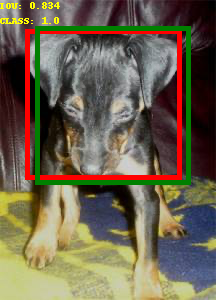

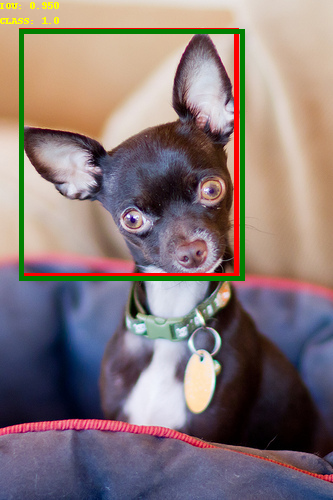

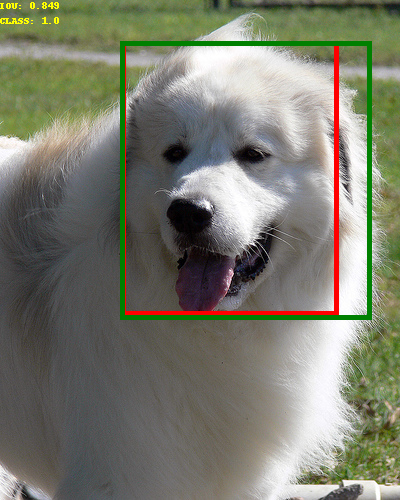

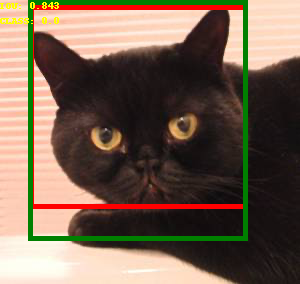

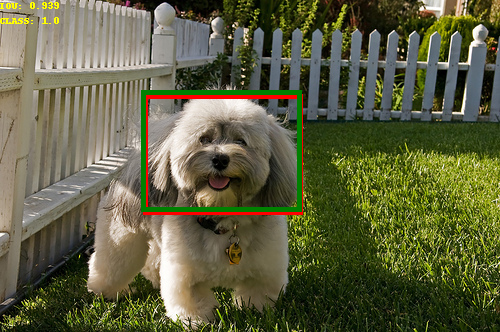

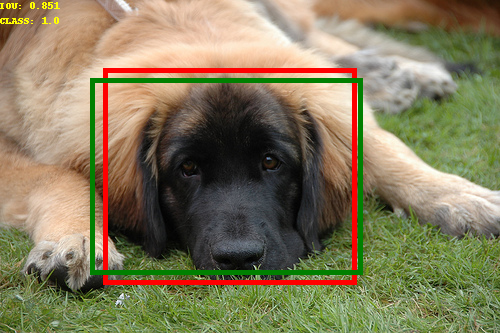

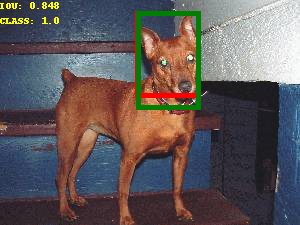

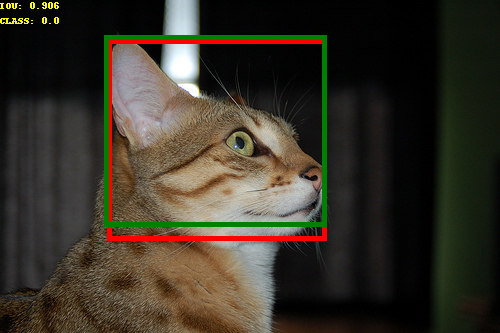

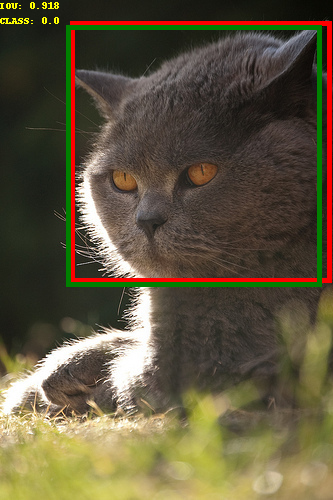

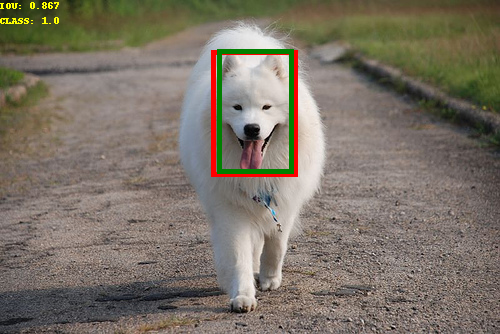

In [417]:
for x in ten_img_list: plot_img_pred_test_set(x) 